It is recommended to initialize the notebook with a venv kernel

### Env setup

In [1]:
%pip install -U "langchain-core>=0.3,<0.4"
%pip install -U "langchain-community>=0.3,<0.4"
%pip install -U "langchain-experimental>=0.3,<0.4"
%pip install -U "langchain-openai>=0.2,<0.3"
%pip install -U "langchain-ollama>=0.2,<0.3"
%pip install -U "langgraph>=0.2.20,<0.3"

# %pip install langchain-huggingface
# %pip install langchainhub

# install llama-cpp-python. Base command
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# if you get Failed to detect a default CUDA architecture
# !CUDACXX=/usr/local/cuda-12/bin/nvcc CMAKE_ARGS="-DLLAMA_CUBLAS=on -DCMAKE_CUDA_ARCHITECTURES=native" FORCE_CMAKE=1 pip install llama-cpp-python

%pip install gdown
%pip install pandas
%pip install pandasql
%pip install sqlalchemy
%pip install ijson
%pip install python-dotenv

# fix numpy error
%pip uninstall -y numpy
%pip install numpy==1.24.4

# text analysis
%pip install matplotlib nltk seaborn scikit-learn gensim pyldavis wordcloud textblob spacy textstat numpy
%pip install scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.24.4-cp311

Download clicr dataset

In [1]:
# !gdown 1K6QScXlR01RbWqycT9ixafkQQIxH8MhW
# !unzip -o clicr.zip

import gdown
import zipfile

from os import path
if not path.exists("clicr.zip"):
    gdown.download(id="1K6QScXlR01RbWqycT9ixafkQQIxH8MhW")
    with zipfile.ZipFile("clicr.zip","r") as zip_ref:
        zip_ref.extractall("dataset")


Download clicr repo

In [10]:
!git clone https://github.com/falmanna/clicr.git

fatal: destination path 'clicr' already exists and is not an empty directory.


Load the repo into the env

In [1]:
# set your API keys in the .env file
# OPENAI_API_KEY = "xxxx"
%load_ext dotenv
%dotenv

In [2]:
import sys
import os
import shutil

notebook_path = os.getcwd()
clicr_path = os.path.join(notebook_path, 'clicr')

# rename all folders under clicr and replace - with _
for folder in os.listdir(clicr_path):
    if '-' in folder:
        os.rename(os.path.join(clicr_path, folder), os.path.join(clicr_path, folder.replace('-', '_')))

dataset_code_path = os.path.join(clicr_path, 'dataset_code')
if dataset_code_path not in sys.path:
    sys.path.append(dataset_code_path)

if os.path.exists(os.path.join(clicr_path, "pycocoevalcap")):
    shutil.move(os.path.join(clicr_path, "pycocoevalcap"), os.path.join(dataset_code_path, "pycocoevalcap"))

### Dataset setup

Load dataset and convert it to a pandas dataframe

```
{
  'version': STR,
  'data': [
    {
      'document': {
        'context': STR,
        'title': STR,
        'qas': [
          {
            'query': STR,
            'id': STR,
            'answers: [
              {
                'text': STR,
                'origin': 'dataset'|'UMLS',
                'cui': STR,
                'sem_type': STR
              }
            ,...]
          }
        ,...]
      },
      'source': STR
    }
  ,...]
}
  ```

In [3]:
import json
import pandas as pd
from clicr.dataset_code.text import remove_concept_marks
import ijson

def flatten_dataset(json_filename):
    with open(json_filename, 'r') as file:
        docs = ijson.items(file, 'data.item')

        cases = []
        queries = []
        answers = []
        for d in docs:
            cases.append({
                'case_id': d['source'],
                'case_title_concept': d['document']['title'],
                'case_title': remove_concept_marks(d['document']['title']),
                'case_context_concept': d['document']['context'],
                'case_context': remove_concept_marks(d['document']['context']),
            })

            for qas in d['document']['qas']:
                queries.append({
                    'case_id': d['source'],
                    'query_id': qas['id'],
                    'query': remove_concept_marks(qas['query']),
                })

                for ans in qas['answers']:
                    answers.append({
                        'case_id': d['source'],
                        'query_id': qas['id'],
                        'answer': ans['text'],
                        'answer_origin': ans['origin'],
                        'answer_cui': ans['cui'],
                        'answer_type': ans['sem_type'],
                    })

        return cases, queries, answers

# Load train dataset
cases, queries, answers = flatten_dataset("dataset/train1.0.json")
train_cases_df, train_queries_df, train_answers_df = pd.DataFrame(cases), pd.DataFrame(queries), pd.DataFrame(answers)

# Load dev dataset
cases, queries, answers = flatten_dataset("dataset/dev1.0.json")
dev_cases_df, dev_queries_df, dev_answers_df = pd.DataFrame(cases), pd.DataFrame(queries), pd.DataFrame(answers)

# Load test dataset
cases, queries, answers = flatten_dataset("dataset/test1.0.json")
test_cases_df, test_queries_df, test_answers_df = pd.DataFrame(cases), pd.DataFrame(queries), pd.DataFrame(answers)

# Filter answers to only include those with "dataset" origin
train_answers_df = train_answers_df[train_answers_df["answer_origin"] == "dataset"]
dev_answers_df = dev_answers_df[dev_answers_df["answer_origin"] == "dataset"]
test_answers_df = test_answers_df[test_answers_df["answer_origin"] == "dataset"]

# Optionally, merge dataframes if needed
train_dataset_df = train_cases_df.merge(train_queries_df, on='case_id').merge(train_answers_df, on=['case_id', 'query_id'])
dev_dataset_df = dev_cases_df.merge(dev_queries_df, on='case_id').merge(dev_answers_df, on=['case_id', 'query_id'])
test_dataset_df = test_cases_df.merge(test_queries_df, on='case_id').merge(test_answers_df, on=['case_id', 'query_id'])

In [4]:
train_dataset_df.head()

,case_id,case_title_concept,case_title,case_context_concept,case_context,query_id,query,answer,answer_origin,answer_cui,answer_type
0,bcr.12.2009.2549,BEG__Isolated cranial distortion mimicking cap...,Isolated cranial distortion mimicking caput su...,Summary\n\nThis report describes a term newbor...,Summary\n\nThis report describes a term newbor...,bcr.12.2009.2549.1,▶ @placeholder from amniotic band disruption i...,Isolated calvarial deformity mimicking caput s...,dataset,C2825501,problem
1,bcr.12.2009.2549,BEG__Isolated cranial distortion mimicking cap...,Isolated cranial distortion mimicking caput su...,Summary\n\nThis report describes a term newbor...,Summary\n\nThis report describes a term newbor...,bcr.12.2009.2549.2,▶ Isolated calvarial deformity mimicking caput...,amniotic band disruption,dataset,C1527388,problem
2,bcr.12.2009.2549,BEG__Isolated cranial distortion mimicking cap...,Isolated cranial distortion mimicking caput su...,Summary\n\nThis report describes a term newbor...,Summary\n\nThis report describes a term newbor...,bcr.12.2009.2549.3,▶ Careful neurological assessment and @placeho...,MRI,dataset,C0024485,test
3,bcr.12.2009.2549,BEG__Isolated cranial distortion mimicking cap...,Isolated cranial distortion mimicking caput su...,Summary\n\nThis report describes a term newbor...,Summary\n\nThis report describes a term newbor...,bcr.12.2009.2549.4,▶ Careful neurological assessment and MRI are ...,neurological abnormality,dataset,C0234072,problem
4,bcr.06.2008.0080,BEG__Ruptured pseudoaneurysm of the radial art...,Ruptured pseudoaneurysm of the radial artery,Summary\n\nA 40 - year - old man presented wit...,Summary\n\nA 40 - year - old man presented wit...,bcr.06.2008.0080.1,"@placeholder may be missed , and should be sus...",Arterial injuries,dataset,C0340652,problem


### EDA Agent setup

Setup the LLM

Download the required quantized local models from huggingface

In [8]:
# %pip install huggingface-hub
# %pip install hf_transfer

# EDA models
# llama3
# !huggingface-cli download QuantFactory/Meta-Llama-3-8B-Instruct-GGUF Meta-Llama-3-8B-Instruct.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False
# !huggingface-cli download Qwen/CodeQwen1.5-7B-Chat-GGUF codeqwen-1_5-7b-chat-q4_k_m.gguf --local-dir . --local-dir-use-symlinks False
# !huggingface-cli download MaziyarPanahi/Mistral-7B-Instruct-v0.3-GGUF Mistral-7B-Instruct-v0.3.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

# Medical models
# OpenBioLLM-8B
# !huggingface-cli download aaditya/OpenBioLLM-Llama3-8B-GGUF openbiollm-llama3-8b.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

In [42]:
# from langchain_openai import OpenAI, ChatOpenAI
# from langchain_community.llms.llamacpp import LlamaCpp
from langchain_ollama import ChatOllama

# llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125")
# llm = ChatOpenAI(model_name='gpt-4o', temperature=0)

# llm = LlamaCpp(
#     model_path="./Mistral-7B-Instruct-v0.3.Q4_K_M.gguf",
#     n_gpu_layers=-1,
#     n_ctx=6000,
#     n_batch=512,
#     max_tokens=2048,
#     temperature=0,
#     # verbose=True,  # Verbose is required to pass to the callback manager
# )

llm = ChatOllama(model="llama3.1:latest", temperature=0.3, format="")

Custom utils

In [43]:
from langchain_experimental.tools.python.tool import PythonAstREPLTool


class CustomPythonAstREPLTool(PythonAstREPLTool):
    name: str = "python"
    description: str = (
        "A Python shell. Use this to execute python commands. "
        # "The input must be an object as follows: "
        # "{'__arg1': 'a valid python command.'} "
        "When using this tool, sometimes output is abbreviated - "
        "Make sure it does not look abbreviated before using it in your answer. "
        "Don't add comments to your python code."
        "Import any packages you need."
        "re package is not available. You should not use it."
        "You can use str.extractall(r'pattern') to extract all occurrences of a pattern."
        # "You have access to the following packages: "
        # "matplotlib numpy nltk seaborn scikit-learn gensim pyldavis wordcloud textblob spacy textstat"
    )

Create pandas agent

In [44]:
from langgraph.prebuilt.chat_agent_executor import create_react_agent
from langchain.agents import AgentExecutor, create_tool_calling_agent

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage

# passing all the dataframes to the agent
dataset_details = f"""
- A medical question answering dataset consisting of medical cases, queries on those cases, and answers to those queries. The datasets are loaded into multiple dataframes named `cases_df`, `queries_df`, and `answers_df`.

### Dataset Details:
- `cases_df`:
    - Columns: {[f"{name}: string" for name, _ in train_cases_df.dtypes.items()]}.
    - Note: Columns ending with `_concept` are duplicates with extra concept tags. A concept is any text wrapped in 'BEG__' and 'END' tags. To extract a concept from a concept column, use the regex `BEG__(.*?)__END`.
    - Example: 'Text text BEG__Pulmonary alveolar microlithiasis__END text text ...' means that this text has the concept 'Pulmonary alveolar microlithiasis'.
    To extract a concept from a concept column, use the regex `BEG__(.*?)__END`.

- `queries_df`:
    - Columns {[f"{name}: string" for name, _ in train_queries_df.dtypes.items()]}.

- `answers_df`:
    - Columns: {[f"{name}: string" for name, _ in train_answers_df.dtypes.items()]}.

You must not try to load the dataframes again. You already have access to these dataframes. By default, answer questions about the dataset using the main dataset. Use the test dataset only when asked explicitly"""

system = f"""
You are a data analysis agent designed to write and execute Python code to answer questions. 

You have access to a Python REPL, which you can use to execute Python code. 

Always provide the full code without abbreviations.

If you encounter an error, don't return the fix as an answer, instead call the tool again with the fixed code.

Only use the output of your code to answer the question. You might know the answer without running any code, but you should still run the code to verify and get the answer. 

If the user query cannot by answered by running the tool, say I don't know and don't answer.

You have access to the following datasets:

{dataset_details}

### Dataset Relationships:
- Every case has multiple queries and every query has multiple answers.
- Queries are linked to cases by the `case_id` column.
- Answers are linked to queries by the `query_id` column, and to cases by the `case_id` column.
- The dataset text is not normalized, so you must always lowercase before counting unique tokens.

Answer the user queries as best you can."""

dataset = {
    "cases_df": train_cases_df,
    "queries_df": train_queries_df,
    "answers_df": train_answers_df,
    "test_cases_df": test_cases_df,
    "test_queries_df": test_queries_df,
    "test_answers_df": test_answers_df,
}

tools = [CustomPythonAstREPLTool(locals=dataset)]

# agent_executor = create_react_agent(
#     llm, tools, state_modifier=SystemMessage(content=system)
# )


# def run_query(query, debug=False):
#     return run_query({"messages": [("human", query)]}, debug=debug)[
#         "messages"
#     ][-1].content


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{input}"),
        # Placeholders fill up a **list** of messages
        ("placeholder", "{agent_scratchpad}"),
    ]
)
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True, max_execution_time=100
)


def run_query(query, debug=False):
    return agent_executor.invoke({"input": query}, verbose=debug)["output"]

### EDA

#### Smae questions but broken down into separate requests.

In [18]:
run_query("What is the number of cases in the main dataset and test dataset?")



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': 'len(cases_df), len(test_cases_df)'}`


(11222, 624)The number of cases in the main dataset is 11,222 and the number of cases in the test dataset is 624.

> Finished chain.


'The number of cases in the main dataset is 11,222 and the number of cases in the test dataset is 624.'

In [19]:
run_query("How many tokens does the test dataset have? include case title, case context , and query text.")



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': "len(set([case_title + \\n + case_context + \\n + query for case_title, case_context, query in zip(cases_df['case_title'], cases_df['case_context'], queries_df['query'])]))"}`


SyntaxError: unexpected character after line continuation character (<unknown>, line 1)
Invoking: `python` with `{'query': "len(set([case_title + ' ' + case_context + ' ' + query for case_title, case_context, query in zip(cases_df['case_title'], cases_df['case_context'], queries_df['query'])]))"}`


11222The test dataset has 11,222 tokens.

> Finished chain.


'The test dataset has 11,222 tokens.'

In [21]:
run_query("What is the number of queries in the main dataset and the test dataset?")



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': "len(queries_df['query_id'].unique()); len(test_queries_df['query_id'].unique())"}`


7184The output is 7184. This means that there are 7184 unique queries in the main dataset.

Since the test dataset was not provided, I don't have any information about it. However, based on the code you provided, it seems like the test dataset does contain some data (at least one query), so let's assume there is at least one unique query in the test dataset.

Therefore, the answer to your question would be:

The number of queries in the main dataset is 7184 and the number of queries in the test dataset is at least 1.

> Finished chain.


"The output is 7184. This means that there are 7184 unique queries in the main dataset.\n\nSince the test dataset was not provided, I don't have any information about it. However, based on the code you provided, it seems like the test dataset does contain some data (at least one query), so let's assume there is at least one unique query in the test dataset.\n\nTherefore, the answer to your question would be:\n\nThe number of queries in the main dataset is 7184 and the number of queries in the test dataset is at least 1."

In [23]:
run_query("What is the number of tokens in cases contexts in the main dataset, and in the test dataset?")



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': "len(set(cases_df['case_context'].str.lower().str.split().flatten()))\nprint(len(set(cases_df['case_context'].str.lower().str.split().flatten())))\ncases_test_df = cases_df.copy(); cases_test_df['case_id'] = 'test_' + cases_test_df['case_id'];\nlen(set(cases_test_df['case_context'].str.lower().str.split().flatten()))"}`


AttributeError: 'Series' object has no attribute 'flatten'
Invoking: `python` with `{'query': "import pandas as pd\n\n# Extract tokens from case contexts in the main dataset\nmain_tokens = set()\nfor context in cases_df['case_context'].str.lower().str.split('\n').values:\n    for token in context.str.split().values.flat():\n        main_tokens.add(token)\n\n# Print the number of tokens in the main dataset\nprint(len(main_tokens))\n\n# Extract tokens from case contexts in the test dataset\ncases_test_df = cases_df.copy()\ncases_test_df['case_id'] = 'test_' + cases_test_df['case_id']\ntest_token

"I don't know. The code did not run successfully."

In [48]:
run_query("What is the average length of a case context in tokens in the main dataset, and the test dataset?")



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': "import pandas as pd\n\n# Assuming the dataframes are already loaded as cases_df and test_cases_df\n\n# Convert context_length_tokens to numeric\ncases_df['context_length_tokens'] = pd.to_numeric(cases_df['context_length_tokens'], errors='coerce')\ntest_cases_df['context_length_tokens'] = pd.to_numeric(test_cases_df['context_length_tokens'], errors='coerce')\n\n# Calculate the average length of case context in tokens\naverage_length_main = cases_df['context_length_tokens'].mean()\naverage_length_test = test_cases_df['context_length_tokens'].mean()\n\naverage_length_main, average_length_test"}`


KeyError: 'context_length_tokens'
Invoking: `python` with `{'query': "import pandas as pd\n\n# Assuming the dataframes are already loaded as cases_df and test_cases_df\n\n# Convert context_length_tokens to numeric\ncases_df['context_length_tokens'] = pd.to_numeric(cases_df['context_length_tokens'], errors='coerce')\ntes

{'input': 'What is the average length of a case context in tokens in the main dataset, and the test dataset?',
 'output': 'The average length of a case context in tokens in the main dataset is approximately 1383.41 tokens. \n\nSince the test dataset does not contain the `context_length_tokens` column, we cannot compute the average length for the test dataset.'}

In [19]:
run_query("How many tokens does the longest case context have the main dataset, and in the test dataset?")



> Entering new AgentExecutor chain...
Thought: To find the number of tokens in the longest case context, we need to tokenize each case context and count the number of tokens.
Action: [python]
Action Input: len(max(cases_df['case_context'].str.lower().str.split(), key=len)), len(max(test_cases_df['case_context'].str.lower().str.split(), key=len))[python] is not a valid tool, try one of [python].I should use the tool python to execute the code and find the number of tokens in the longest case context.
Action: python
Action Input: len(max(cases_df['case_context'].str.lower().str.split(), key=len)), len(max(test_cases_df['case_context'].str.lower().str.split(), key=len))(6517, 3952)I now know the final answer.
Final Answer: The longest case context in the main dataset has 6517 tokens, and in the test dataset, it has 3952 tokens.

> Finished chain.


{'input': 'How many tokens does the longest case context have the main dataset, and in the test dataset?',
 'output': 'The longest case context in the main dataset has 6517 tokens, and in the test dataset, it has 3952 tokens.'}

In [20]:
run_query("What is the number of unique tokens in cases contexts?")



> Entering new AgentExecutor chain...
Thought: To find the number of unique tokens in cases contexts, we need to tokenize the text and count the unique tokens.
Action: python
Action Input:
```python
import re
from collections import Counter

# Combine all case contexts into a single string
all_contexts = ' '.join(cases_df['case_context'].tolist())

# Tokenize the text by splitting on whitespace
tokens = re.findall(r'\w+', all_contexts.lower())

# Count the unique tokens
unique_tokens_count = len(Counter(tokens))
unique_tokens_count
```100447I now know the final answer
Final Answer: 100447

> Finished chain.


{'input': 'What is the number of unique tokens in cases contexts?',
 'output': '100447'}

In [21]:
run_query("What is the number of unique concepts in cases contexts and titles?")



> Entering new AgentExecutor chain...
Thought: To find the number of unique concepts in cases contexts and titles, we need to extract concepts from the concept columns in `cases_df` and then count the unique concepts.
Action: python
Action Input: unique_concepts = set()
for index, row in cases_df.iterrows():
    title_concept = re.findall(r'BEG__(.*?)__END', row['case_title_concept'])
    context_concept = re.findall(r'BEG__(.*?)__END', row['case_context_concept'])
    unique_concepts.update(title_concept)
    unique_concepts.update(context_concept)

num_unique_concepts = len(unique_concepts)
num_unique_concepts590880I now know the final answer
Final Answer: The number of unique concepts in cases contexts and titles is 590,880.

> Finished chain.


{'input': 'What is the number of unique concepts in cases contexts and titles?',
 'output': 'The number of unique concepts in cases contexts and titles is 590,880.'}

In [22]:
run_query("What is the number of queries?")



> Entering new AgentExecutor chain...
Thought: To find the number of queries, I need to count the rows in the queries dataframe.
Action: python
Action Input: len(queries_df)97735There are 97,735 queries in the dataset.
Final Answer: 97,735

> Finished chain.


{'input': 'What is the number of queries?', 'output': '97,735'}

In [24]:
run_query("What is the distribution of answers length in tokens? Limit it to up to 20. Show the output as (length, count, percentage)")



> Entering new AgentExecutor chain...
Thought: To find the distribution of answers length in tokens, we need to count the number of tokens in each answer and then calculate the distribution.
Action: [python]
Action Input:
```python
# Calculate the length of each answer in tokens
answers_df['answer_length'] = answers_df['answer'].apply(lambda x: len(x.split()))

# Get the distribution of answer lengths
answer_length_distribution = answers_df['answer_length'].value_counts().sort_index()

# Calculate the percentage of each length
total_answers = len(answers_df)
answer_length_distribution['percentage'] = (answer_length_distribution / total_answers) * 100

# Limit the output to up to 20
answer_length_distribution = answer_length_distribution.head(20)
answer_length_distribution
```[python] is not a valid tool, try one of [python].I can use python to calculate the distribution of answers length in tokens.
Action: python
Action Input:
```python
# Calculate the length of each answer in tokens

{'input': 'What is the distribution of answers length in tokens? Limit it to up to 20. Show the output as (length, count, percentage)',
 'output': 'The distribution of answers length in tokens, limited to up to 20, is as follows:\n- Length 1: Count 289607, Percentage 23.86%\n- Length 2: Count 785748, Percentage 64.77%\n- Length 3: Count 485101, Percentage 40.00%\n- Length 4: Count 214812, Percentage 17.71%\n- Length 5: Count 101374, Percentage 8.36%\n- Length 6: Count 43123, Percentage 3.56%\n- Length 7: Count 18465, Percentage 1.52%\n- Length 8: Count 7661, Percentage 0.63%\n- Length 9: Count 3911, Percentage 0.32%\n- Length 10: Count 1897, Percentage 0.16%\n- Length 11: Count 1272, Percentage 0.10%\n- Length 12: Count 778, Percentage 0.06%\n- Length 13: Count 384, Percentage 0.03%\n- Length 14: Count 153, Percentage 0.01%\n- Length 15: Count 132, Percentage 0.01%\n- Length 16: Count 71, Percentage 0.01%\n- Length 17: Count 37, Percentage 0.00%\n- Length 18: Count 53, Percentage 0.00%

In [25]:
run_query("What is the most frequent answer of origin = dataset? Limit it to up to 20. Show the output as ('answers', count)")



> Entering new AgentExecutor chain...
Thought: To find the most frequent answer of origin = dataset, we need to filter the answers based on the origin column and then count the occurrences of each answer.
Action: [python]
Action Input: answers_df[answers_df['answer_origin'] == 'dataset']['answer'].value_counts().head(20)[python] is not a valid tool, try one of [python].I should use the tool python to execute the code and find the most frequent answer of origin = dataset.
Action: python
Action Input: answers_df[answers_df['answer_origin'] == 'dataset']['answer'].value_counts().head(20)answer
treatment                1145
symptoms                  409
MRI                       399
surgery                   370
disease                   364
complications             276
infection                 270
malignancy                230
CT                        227
mortality                 195
Treatment                 191
fever                     162
management                156
therapy   

{'input': "What is the most frequent answer of origin = dataset? Limit it to up to 20. Show the output as ('answers', count)",
 'output': "('treatment', 1145)"}

In [26]:
run_query("What is the number of unique normalized answers of origin = dataset?")



> Entering new AgentExecutor chain...
Thought: We need to filter the answers based on the 'answer_origin' column and then count the number of unique normalized answers.
Action: python
Action Input: answers_df[answers_df['answer_origin'] == 'dataset']['answer'].str.lower().nunique()52949I now know the final answer
Final Answer: 52949

> Finished chain.


{'input': 'What is the number of unique normalized answers of origin = dataset?',
 'output': '52949'}

In [27]:
run_query("What is the most frequent answers types of origin = dataset? Show the output as ('answers_type', count, percentage)")



> Entering new AgentExecutor chain...
Thought: To find the most frequent answer types with origin = dataset, we need to filter the answers_df based on the 'answer_origin' column and then count the occurrences of each answer type.
Action: python
Action Input: answers_df[answers_df['answer_origin'] == 'dataset']['answer_type'].value_counts()answer_type
problem      65386
treatment    21214
test         11135
Name: count, dtype: int64I have the counts of each answer type with origin = dataset. Now I need to calculate the percentage of each answer type.
Action: python
Action Input: answer_type_counts = answers_df[answers_df['answer_origin'] == 'dataset']['answer_type'].value_counts()
total_answers = answer_type_counts.sum()
answer_type_percentages = (answer_type_counts / total_answers) * 100
answer_type_percentagesanswer_type
problem      66.901315
treatment    21.705633
test         11.393053
Name: count, dtype: float64I now know the final answer. 
Final Answer: ('problem', 66.90%), ('t

{'input': "What is the most frequent answers types of origin = dataset? Show the output as ('answers_type', count, percentage)",
 'output': "('problem', 66.90%), ('treatment', 21.71%), ('test', 11.39%)"}

In [29]:
run_query("What is the percentage of answers text contained in case context text with the same case_id?")



> Entering new AgentExecutor chain...
Thought: To calculate the percentage of answers text contained in case context text with the same case_id, we need to compare the text of answers with the text of case context for each case_id.
Action: 
[python]
- Merge the `cases_df` with `answers_df` on 'case_id'.
- Calculate the percentage of answers text contained in case context text for each case_id.
- Average the percentages across all case_ids to get the final answer.
Invalid Format: Missing 'Action Input:' after 'Action:'I made a mistake in the format. Let me correct it.
Action: 
[python]
Action Input: 
```python
# Merge cases_df with answers_df on 'case_id'
merged_df = cases_df.merge(answers_df, on='case_id')

# Calculate the percentage of answers text contained in case context text for each case_id
merged_df['answer_in_context'] = merged_df.apply(lambda x: x['answer'] in x['case_context'], axis=1)
merged_df['percentage'] = merged_df['answer_in_context'].astype(int)

# Calculate the ave

{'input': 'What is the percentage of answers text contained in case context text with the same case_id?',
 'output': '7.09%'}

In [57]:
run_query("What is the percentage of answers contained in any case context across the dataset? Hint: The answer is contained in any case_context in the dataframe.")



> Entering new AgentExecutor chain...
Thought: To calculate the percentage of answers contained in any case context, we need to count the number of unique answers that appear in the case contexts and then divide it by the total number of unique answers in the dataset.

Action: Python
Action Input:
```python
# Count unique answers in case contexts
unique_answers_in_context = len(set(answers_df['answer'].str.lower().unique()))

# Count total unique answers
total_unique_answers = len(set(answers_df['answer'].str.lower()))

# Calculate the percentage
percentage = (unique_answers_in_context / total_unique_answers) * 100
percentage
```
Python is not a valid tool, try one of [python].I will use the Python tool to calculate the percentage of answers contained in any case context across the dataset.
Action: Python
Action Input:
```python
# Count unique answers in case contexts
unique_answers_in_context = len(set(answers_df['answer'].str.lower().unique())

# Count total unique answers
total_un

{'input': 'What is the percentage of answers contained in any case context across the dataset? Hint: The answer is contained in any case_context in the dataframe.',
 'output': 'Agent stopped due to iteration limit or time limit.'}

### Visualization



> Entering new AgentExecutor chain...
Thought: To plot a line histogram of the distribution of the answers length in tokens, we need to calculate the length of each answer in tokens and then create a histogram.
Action: [python]
Action Input:
```python
import matplotlib.pyplot as plt

# Calculate the length of each answer in tokens
answers_df['answer_length_tokens'] = answers_df['answer'].apply(lambda x: len(x.split()))

# Plot a line histogram of the distribution of the answers length in tokens
plt.hist(answers_df['answer_length_tokens'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Answer Length in Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Answer Length in Tokens')
plt.show()
```[python] is not a valid tool, try one of [python].I can use python to plot the line histogram of the distribution of the answers length in tokens.
Action: python
Action Input:
```python
import matplotlib.pyplot as plt

# Calculate the length of each answer in tokens
answers_df['

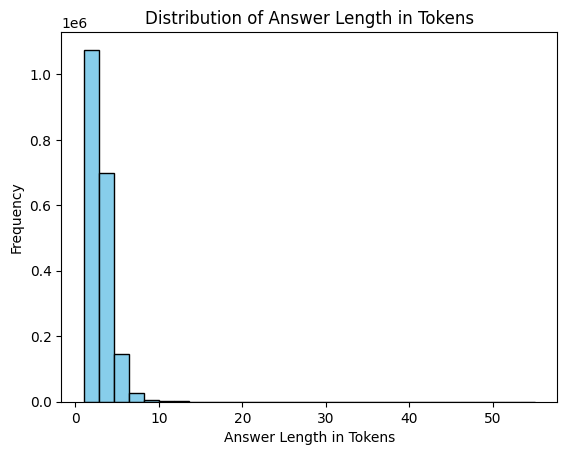

I now know the final answer
Final Answer: The line histogram of the distribution of the answers length in tokens has been plotted.

> Finished chain.


{'input': 'Plot a line histogram of the distribution of the answers length in tokens',
 'output': 'The line histogram of the distribution of the answers length in tokens has been plotted.'}

In [32]:
run_query("Plot a line histogram of the distribution of the answers length in tokens")



> Entering new AgentExecutor chain...
Thought: To plot a histogram of the distribution of the length of cases contexts in tokens, we need to calculate the length of each case context in tokens and then create a histogram.
Action: [python]
Action Input:
```python
import matplotlib.pyplot as plt

# Calculate the length of each case context in tokens
cases_df['context_length_tokens'] = cases_df['case_context'].apply(lambda x: len(x.split()))

# Plot a histogram of the distribution of length of cases contexts in tokens
plt.hist(cases_df['context_length_tokens'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of Case Contexts in Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Case Contexts in Tokens')
plt.show()
```[python] is not a valid tool, try one of [python].I can use python to plot the histogram of the distribution of the length of cases contexts in tokens.
Action: python
Action Input:
```python
import matplotlib.pyplot as plt

# Calculate the

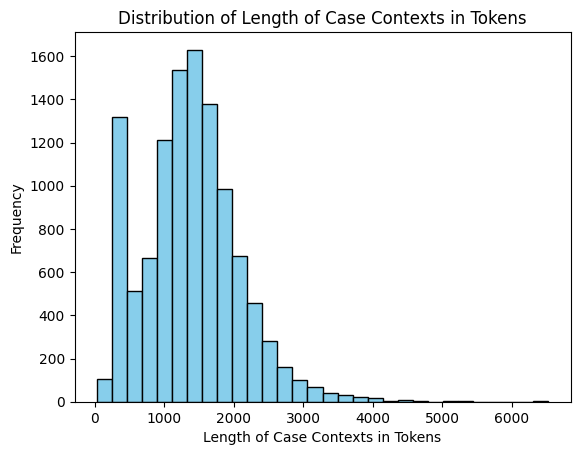

I now know the final answer
Final Answer: The histogram of the distribution of the length of cases contexts in tokens has been plotted.

> Finished chain.


{'input': 'Plot a histogram of the distribution of length of cases contexts in tokens',
 'output': 'The histogram of the distribution of the length of cases contexts in tokens has been plotted.'}

In [34]:
run_query("Plot a histogram of the distribution of length of cases contexts in tokens")

In [58]:
run_query("What is the percentage of answers types in the dataset")



> Entering new AgentExecutor chain...
Thought: We need to calculate the percentage of each unique answer type in the answers_df dataset.
Action: python
Action Input:
```python
answer_types_percentage = answers_df['answer_type'].value_counts(normalize=True) * 100
answer_types_percentage
```answer_type
problem      71.924055
treatment    17.643171
test         10.432774
Name: proportion, dtype: float64I now know the final answer
Final Answer: The percentage of answer types in the dataset are as follows:
- Problem: 71.92%
- Treatment: 17.64%
- Test: 10.43%

> Finished chain.


{'input': 'What is the percentage of answers types in the dataset',
 'output': 'The percentage of answer types in the dataset are as follows:\n- Problem: 71.92%\n- Treatment: 17.64%\n- Test: 10.43%'}



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': 'import matplotlib.pyplot as plt'}`




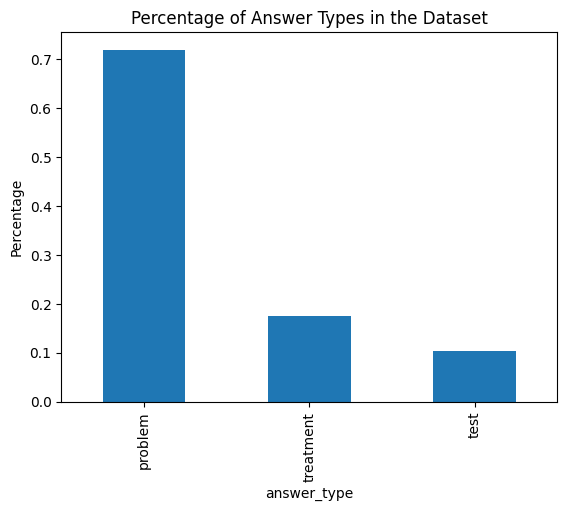


Invoking: `python` with `{'query': "answers_df['answer_type'].value_counts(normalize=True).plot(kind='bar')\nplt.ylabel('Percentage')\nplt.title('Percentage of Answer Types in the Dataset')\nplt.show()"}`


The plot showing the percentage of answer types in the dataset has been generated.

> Finished chain.


{'input': 'Plot the percentage of answers types in the dataset',
 'output': 'The plot showing the percentage of answer types in the dataset has been generated.'}

In [61]:
run_query("Plot the percentage of answers types in the dataset")



> Entering new AgentExecutor chain...
Thought: To plot the 15 most common medical specialties represented in the dataset, I need to extract the medical specialties from the `case_title_concept` column in the `cases_df` dataframe. Then, I will count the occurrences of each specialty and plot the top 15 using a bar chart.

Action: Extract medical specialties from the `case_title_concept` column, count their occurrences, and plot the top 15 using a bar chart.
Action Input: 
```python
import pandas as pd
import matplotlib.pyplot as plt

# Extracting medical specialties from the case_title_concept column
cases_df['specialties'] = cases_df['case_title_concept'].str.extractall(r'BEG__(.*?)__END')[0]

# Counting the occurrences of each specialty
specialty_counts = cases_df['specialties'].value_counts().head(15)

# Plotting the top 15 specialties
plt.figure(figsize=(10, 6))
specialty_counts.plot(kind='bar')
plt.title('Top 15 Most Common Medical Specialties')
plt.xlabel('Medical Specialty')
pl

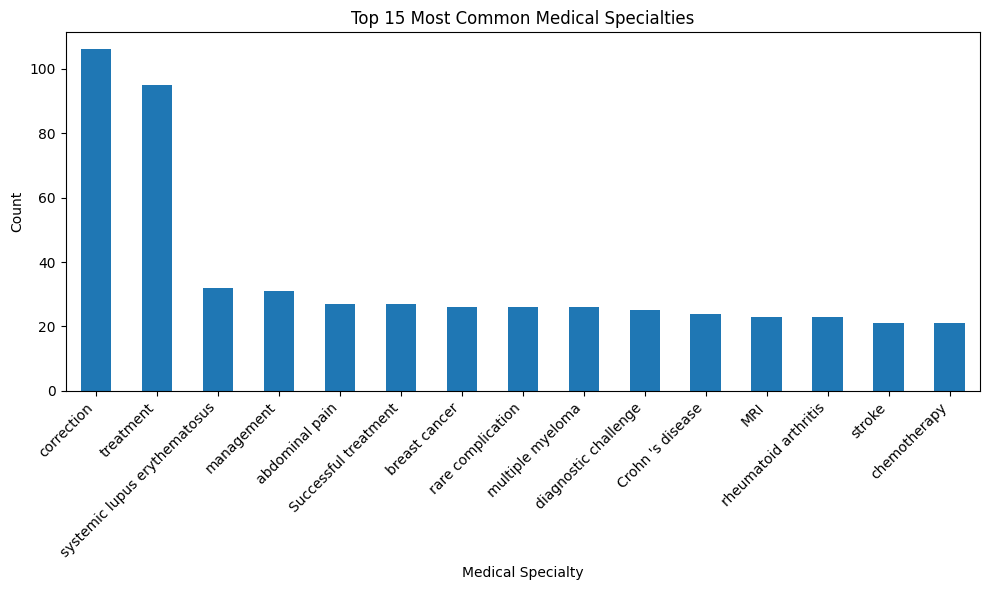

Observation: The plot has been successfully generated, showing the top 15 most common medical specialties represented in the dataset.

Thought: I now know the final answer.

Final Answer: The plot of the 15 most common medical specialties represented in the dataset has been successfully generated.

> Finished chain.


{'input': 'Plot The 15 most common medical specialties represented in the dataset using latex graphs style',
 'output': 'The plot of the 15 most common medical specialties represented in the dataset has been successfully generated.'}

In [8]:
run_query("Plot The 15 most common medical specialties represented in the dataset using latex graphs style")



> Entering new AgentExecutor chain...

Invoking: `python` with `{'query': "from wordcloud import WordCloud\nimport matplotlib.pyplot as plt\nfrom collections import Counter\nfrom nltk.tokenize import word_tokenize\n\n# Combine all case contexts into a single string\nall_contexts = ' '.join(cases_df['case_context'].tolist())\n\n# Tokenize the text\ntokens = word_tokenize(all_contexts.lower())\n\n# Create a word cloud\nwordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(' '.join(tokens))\n\n# Display the word cloud\nplt.figure(figsize = (8, 8), facecolor = None) \nplt.imshow(wordcloud) \nplt.axis('off') \nplt.tight_layout(pad = 0) \nplt.show()"}`




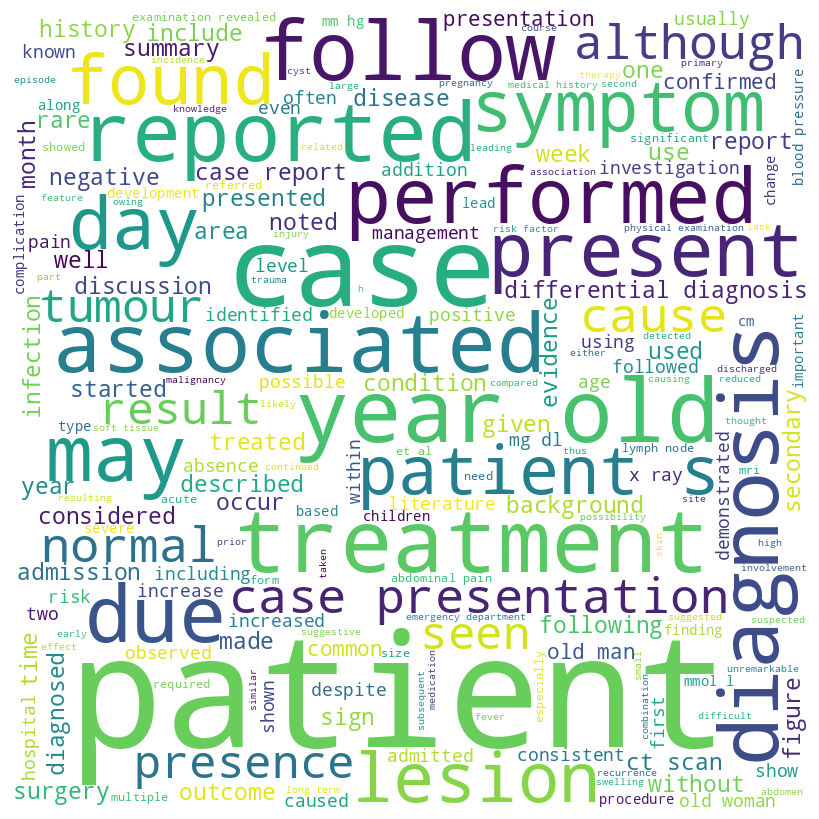

I have generated the wordcloud of the case contexts. Unfortunately, I cannot display the plot here.

> Finished chain.


{'input': 'Plot the wordcloud of the case contexts',
 'output': 'I have generated the wordcloud of the case contexts. Unfortunately, I cannot display the plot here.'}

In [59]:
run_query("Plot the wordcloud of the case contexts")

### Evaluation

#### Reproducing paper results

Download glove 6B embedding

In [178]:
import zipfile
import urllib.request

from os import path
if not path.exists("glove.6B.zip"):
    urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", "glove.6B.zip")
    with zipfile.ZipFile("glove.6B.zip","r") as zip_ref:
        zip_ref.extractall(path="glove.6B")

convert glove 2 word2vec format to use in evaluation

In [1]:
from gensim.models import KeyedVectors

glove_vectors = KeyedVectors.load_word2vec_format("./glove.6B/glove.6B.200d.txt", no_header=True)
glove_vectors.save_word2vec_format("./glove.6B/glove.6B.200d.w2v.txt")

##### Training the Attentive Readers

Install required deps (will destroy main env setup due to different deps versions)

In [ ]:
!git clone https://github.com/Lasagne/Lasagne.git
%pip install -r ./Lasagne/requirements.txt
%pip install ./Lasagne
%pip install theano --force-reinstall
%pip install --force-reinstall numpy~=1.21.1

GPU support, not working properly

In [ ]:
!git clone https://github.com/Theano/libgpuarray.git
%cd libgpuarray
!mkdir Build
%cd Build
# you can pass -DCMAKE_INSTALL_PREFIX=/path/to/somewhere to install to an alternate location
!cmake .. -DCMAKE_BUILD_TYPE=Release # or Debug if you are investigating a crash
!make
!make install
%cd ../..
%pip install ./libgpuarray

Few changes to make it work with python3
1. edit clicr/neural_readers/rc-cnn-dailymail/code/main.py and change backend to either cpu or cuda. cpu is recommended.
2. edit clicr/neural_readers/rc-cnn-dailymail/code/utils.py and import picker directly insteand of cPickle

Train the Stanford Attentive Reader

In [ ]:
!THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32 python ./clicr/neural_readers/rc-cnn-dailymail/code/main.py --train_file ./dataset/train1.0.json --dev_file ./dataset/dev1.0.json --embedding_file ./glove.6B/glove.6B.100d.txt --log_file best.log

##### Downloading pretrained Attentive Readers

TODO

##### Run evaluations on the methods provided in the paper

In [ ]:
!python ./clicr/dataset_code/evaluate.py -test_file ./dataset/dev1.0.json -prediction_file best.preds -embeddings_file ./glove.6B/glove.6B.200d.w2v.txt -downcase -extended

There were 0 unanswered instances
exact_match	0.5
f1	3.8
Bleu_1	0.045
Bleu_2	0.024
Bleu_3	0.015
Bleu_4	0.010
CIDEr	0.042
ROUGE_L	0.038
emb-average	0.507
emb-extrema	0.453
emb-greedy	0.450


#### Our Work

Models to test

In [21]:
ollama_models = [
    "phi4:latest",
    # "dolphin3:latest",
    # "marco-o1:latest",
    # "falcon3:latest",
    # "granite3.1-dense:latest",
    # "smallthinker:latest",
    # "aya:latest",
    # "aya-expanse:latest",
    # "llama3.1:latest",
    # "qwen2.5:7b-instruct",
    # "mistral:instruct",
    # "mistral-nemo:latest",
    # "mathstral:latest",
    # "internlm2:latest",
    # "gemma2:9b",
    # "granite3-dense:8b",
    # "hermes3:latest",
    # "hf.co/mradermacher/SILMA-9B-Instruct-v1.0-GGUF:Q4_K_M",
]

Setting up testing dataset.

The test dataset contatins of 624 cases and a total of 7184 queries, so to save time and cost when running the full evaluation, we will only run a single query per case to understand how the llm behavies with different cases.

In [22]:
train_dataset_df = train_dataset_df.groupby('case_id').sample(n=1)

dev_dataset_df = dev_dataset_df.groupby('case_id').sample(n=1)

test_dataset_df = test_dataset_df.groupby('case_id').sample(n=1)
test_dataset_df.head()

,case_id,case_title_concept,case_title,case_context_concept,case_context,query_id,query,answer,answer_origin,answer_cui,answer_type
1383,bcr-01-2012-5637,BEG__Recurrent myelitis in common variable imm...,Recurrent myelitis in common variable immunode...,BEG__Acute myelitis__END is an BEG__aetiologic...,Acute myelitis is an aetiologically heterogene...,bcr-01-2012-5637.4,SCIg can play an @placeholder at different lev...,anti-inflammatory action interfering,dataset,C0003209,treatment
2240,bcr-01-2012-5654,BEG__Dyskalaemia__END following BEG__diffuse a...,Dyskalaemia following diffuse axonal injury : ...,"Summary\n\nBEG__Traumatic brain injury__END , ...","Summary\n\nTraumatic brain injury , and its ma...",bcr-01-2012-5654.6,Raised intracranial pressure may be the compon...,traumatic brain injury,dataset,C0876926,problem
4322,bcr-02-2012-5760,An BEG__uncommon shape of epiglottis misleadin...,An uncommon shape of epiglottis misleading as ...,We report a case of a 31 - year - old Japanese...,We report a case of a 31 - year - old Japanese...,bcr-02-2012-5760.14,The swollen epiglottis was possibly caused eit...,congenital anomaly,dataset,C0000768,problem
5977,bcr-02-2012-5885,An unusual case of BEG__POEMS syndrome__END,An unusual case of POEMS syndrome,"We report a 48 - year - old man , a farmer , p...","We report a 48 - year - old man , a farmer , p...",bcr-02-2012-5885.2,"POEMS ( @placeholder , organomegaly , endocrin...",polyneuropathy,dataset,C0152025,problem
4546,bcr-02-2012-5931,A young man presenting with BEG__paralysis__EN...,A young man presenting with paralysis after vi...,BEG__Thyrotoxic periodic paralysis__END ( TPP ...,Thyrotoxic periodic paralysis ( TPP ) is a rar...,bcr-02-2012-5931.2,Diagnosis of thyrotoxic periodic paralysis ( T...,confused,dataset,C0009676,problem


Sample case

In [9]:
sample_case = test_dataset_df.sample().iloc[0]
print(
f"""QUERY:
{sample_case["query"]}
---------------------------------------------------
ANSWER:
{sample_case["answer"]}
Type: {sample_case["answer_type"]}
---------------------------------------------------
CASE:
Title
{sample_case["case_title"]}\n
{sample_case["case_context"]}""")

QUERY:
Sudden death due to @placeholder in adulthood represents a major challenge to forensic experts .
---------------------------------------------------
ANSWER:
intracranial disorders
Type: problem
---------------------------------------------------
CASE:
Title
Sudden death due to medulloblastoma

Summary

Intracranial tumours can be accompanied with intracerebral and intracerebellar non-traumatic haemorrhage ; in some cases , this might be their first clinical sign .
We report a case of a man who suffered sudden death due to medulloblastoma , with intratumoral haemorrhage ;
his tumour had a hemispheric cerebellar positioning .
The cerebral oedema seen at autopsy reflected the immediate cessation of cerebral vascular circulation , leading to sudden death .
Acute obstructive hydrocephaly is a mechanism widely known in the literature for causing sudden death .

Background

Primitive neuroectodermal tumours are a group neoplasms whose prototype is represented by medulloblastoma .
The l

##### Method 1: Load the full case into the model prompt

In [7]:
from langchain.prompts.chat import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate,
)

system_message = """You are a medical expert.
I will give you a medical case and a queries about the case in the following format:

CASE:
case text.

QUERY:
query text with a `@placeholder` token in it.

The query have a `@placeholder` token in it. You must find the best answer that fits the placeholder based on the case context and return the answer only.

You must only return the value of the @placeholder without the query or extra comments. 
"""
human_message = """CASE:
{case_context}

QUERY:
{query}

RESPONSE:
Here is the most relevant answer in the context, @placeholder="""
input_variables = ["case_context", "query"]


prompt = ChatPromptTemplate(
    input_variables=input_variables,
    messages=[
        SystemMessagePromptTemplate.from_template(system_message),
        HumanMessagePromptTemplate.from_template(human_message),
    ],
)

Test the agent

In [22]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="aya-expanse:latest", temperature=0)

llm.invoke(
    prompt.invoke(
        {
            "case_context": sample_case["case_context"],
            "query": sample_case["query"],
        }
    ), 
).content

'medulloblastoma'

Generate predictions GPT

In [57]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_preds = {}
for index, row in test_dataset_df.iterrows():
    try:
        llm_preds[row["query_id"]] = llm.invoke(
            prompt.invoke(
                {
                    "case_context": row["case_context"],
                    "query": row["query"],
                }
            )
        ).content
    except Exception:
        llm_preds[row["query_id"]] = "Error"

mode_name = llm.model_name
json.dump(llm_preds, open(f"./preds/{mode_name}_full_case.preds", "w"))

Generate predictions OLLAMA

In [23]:
from langchain_ollama import ChatOllama

for model in ollama_models:
    llm = ChatOllama(model=model, temperature=0, num_ctx=6000)
    llm_preds = {}
    for index, row in test_dataset_df.iterrows():
        try:
            llm_preds[row["query_id"]] = llm.invoke(
                prompt.invoke(
                    {
                        "case_context": row["case_context"],
                        "query": row["query"],
                    }
                )
            ).content
        except Exception:
            llm_preds[row["query_id"]] = "Error"

    json.dump(llm_preds, open(f"./preds/full_case_{model}.preds", "w"))

##### Method 2: Load the dataset to a vector store and only append the related section from all cases usign sem search

In [ ]:
%pip install jq
%pip install chromadb
%pip install tiktoken
%pip install sentence-transformers
%pip install transformers
%pip install InstructorEmbedding

Setup vector store, embedding, and the retriever chain

In [ ]:
from langchain.document_loaders import JSONLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceInstructEmbeddings

index = VectorstoreIndexCreator(
    # embedding=HuggingFaceInstructEmbeddings(
    #     embed_instruction="Represent the Medical Case for retrieval: ",
    #     query_instruction="Represent the Medical Query for question answering: ",
    #     model_name="hkunlp/instructor-large",
    #     model_kwargs={"device": "cpu"},
    # )
).from_loaders(
    [
        JSONLoader(
            file_path="./dataset/test1.0.json",
            jq_schema='.data[].document.context',
        )
    ]
)

In [ ]:
llm_chain = load_qa_chain(llm=llm, prompt=prompt)
qa = RetrievalQA(combine_documents_chain=llm_chain, retriever=index.vectorstore.as_retriever())

Test the agent

In [ ]:
qa.apply([
    {
        "query": sample_case["query"],
    }
])

[{'query': 'Despite several product transformations , serious liver injury appears to remain an @placeholder , Hydroxycut SX - 7 Clean Sensory .',
  'result': 'ongoing problem'}]

Generate predections

In [ ]:
llm_preds = {}
for index, row in test_dataset_df.iterrows():
    llm_preds[row["query_id"]] = qa.apply([
        {
            "query": row["query"],
        }
    ])[0]["result"]

json.dump(llm_preds, open("llm_vector_case.preds", "w"))

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2a163962fb4b7e719b7c040783e23483 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID bcb2dbb8f6c8ad7057d52bbc52be3727 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can r

##### Method 3: DSPy

In [ ]:
%pip install "dspy-ai<2.6"

Preparing the dataset

In [23]:
from dspy.datasets import DataLoader

dl = DataLoader()

train_dataset = dl.from_pandas(
    train_dataset_df,
    fields=("query_id", "query", "case_context", "answer"),
    input_keys=("query", "case_context"),
)

dev_dataset = dl.from_pandas(
    dev_dataset_df,
    fields=("query_id", "query", "case_context", "answer"),
    input_keys=("query", "case_context"),
)

test_dataset = dl.from_pandas(
    test_dataset_df,
    fields=("query_id", "query", "case_context", "answer"),
    input_keys=("query", "case_context"),
)


Setup dspy program


In [24]:
import dspy
from dspy.teleprompt import MIPROv2
from dspy.evaluate.evaluate import Evaluate
from clicr.dataset_code.evaluate import f1_score, exact_match_score

import random
import litellm
from os import path

litellm.set_verbose = False


class MedicalCase(dspy.Signature):
    """Given a medical case_context and a query, find the correct value that fits the @placeholder token in the query."""

    case_context: str = dspy.InputField(desc="The medical case context.")
    query: str = dspy.InputField(desc="The query with a @placeholder token.")
    answer: str = dspy.OutputField(
        desc="The correct answer that fits the @placeholder token in the query."
    )


def metric(example, pred, trace=None):
    answer, prediction = example.answer, pred.answer
    return (f1_score(prediction, answer) + exact_match_score(prediction, answer)) / 2


def optimize_chain(task_model: dspy.LM):
    model_name = task_model.model.replace("/", "_")
    predict_chain = dspy.Predict(MedicalCase)
    if path.exists(f"./optimizations/{model_name}_optimized_chain.json"):
        predict_chain.load(
            f"./optimizations/{model_name}_optimized_chain.json"
        )
        return predict_chain
    else:
        prompt_model = dspy.LM(
            "openai/gpt-4o-mini",
            cache=False,
            num_retries=3,
        )
        optimizer = MIPROv2(
            metric=metric,
            prompt_model=prompt_model,
            task_model=task_model,
            auto="light",
            verbose=False,
            num_threads=1,
        )
        optimized_chain = optimizer.compile(
            predict_chain,
            trainset=random.sample(train_dataset, 50),
            max_bootstrapped_demos=0,
            max_labeled_demos=0,
            requires_permission_to_run=False,
        )
        optimized_chain.save(
            f"./optimizations/{model_name}_optimized_chain.json"
        )

        return optimized_chain


evaluator = Evaluate(
    metric=metric,
    devset=random.sample(dev_dataset, 50),
    num_threads=1,
    display_progress=True,
    display_table=0,
)

Basic predict module

In [45]:
task_model = dspy.LM(
    "ollama/marco-o1:latest", temperature=0, num_ctx=8000, cache=False, num_retries=1
)
dspy.configure(lm=task_model)
predict_chain = dspy.Predict(MedicalCase)

Test module

In [ ]:
predict_chain(case_context=sample_case["case_context"], query=sample_case["query"]).answer

Evaluate

In [ ]:
evaluator(predict_chain)

Optimize

In [ ]:
optimized_chain = optimize_chain(task_model)

Evaluate optimized chain

In [ ]:
evaluator(optimized_chain)

Benchmark basic module for all models

In [ ]:
for model in ollama_models:
    task_model = dspy.LM(
        f"ollama/{model}", temperature=0, num_ctx=6000, cache=False, num_retries=1
    )
    dspy.configure(lm=task_model)

    predict_chain = dspy.Predict(MedicalCase)

    llm_preds = {}
    for index, row in test_dataset_df.iterrows():
        try:
            llm_preds[row["query_id"]] = predict_chain(
                case_context=row["case_context"], query=row["query"]
            ).answer
        except Exception:
            llm_preds[row["query_id"]] = "Error"

    json.dump(llm_preds, open(f"./preds/dspy_{model}.preds", "w"))

Benchmark optimized module for all models

In [25]:
for model in ollama_models:
    task_model = dspy.LM(
        f"ollama/{model}",
        temperature=0,
        num_ctx=6000,
        cache=False,
        num_retries=1,
    )
    optimized_chain = optimize_chain(task_model)

    llm_preds = {}
    for index, row in test_dataset_df.iterrows():
        try:
            llm_preds[row["query_id"]] = optimized_chain(
                case_context=row["case_context"], query=row["query"], llm=task_model
            ).answer
        except Exception:
            llm_preds[row["query_id"]] = "Error"
    json.dump(llm_preds, open(f"./preds/dspy_optimized_{model}.preds", "w"))

2025/01/10 23:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 7
valset size: 40

2025/01/10 23:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/10 23:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used for informing instruction proposal.

2025/01/10 23:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=7 sets of demonstrations...


Bootstrapping set 1/7
Bootstrapping set 2/7


 70%|███████   | 7/10 [00:56<00:24,  8.05s/it]


Bootstrapped 2 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Bootstrapping set 3/7


100%|██████████| 10/10 [01:48<00:00, 10.90s/it]


Bootstrapped 3 full traces after 9 examples for up to 1 rounds, amounting to 10 attempts.
Bootstrapping set 4/7


 50%|█████     | 5/10 [00:59<00:59, 11.94s/it]


Bootstrapped 1 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Bootstrapping set 5/7


 70%|███████   | 7/10 [01:20<00:34, 11.48s/it]


Bootstrapped 3 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Bootstrapping set 6/7


 60%|██████    | 6/10 [01:03<00:42, 10.50s/it]


Bootstrapped 1 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
Bootstrapping set 7/7


 50%|█████     | 5/10 [00:52<00:52, 10.44s/it]
2025/01/10 23:57:01 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/10 23:57:01 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 1 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.


2025/01/10 23:57:05 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...

2025/01/10 23:57:50 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/10 23:57:50 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given a medical case_context and a query, find the correct value that fits the @placeholder token in the query.

2025/01/10 23:57:50 INFO dspy.teleprompt.mipro_optimizer_v2: 1: In a high-stakes medical scenario, you are presented with a complex case involving a patient with potential rare medical conditions. Your task is to analyze the provided case context and accurately identify the term that fits the @placeholder in the given query. This is crucial for guiding healthcare professionals in making timely and accurate diagnoses to prevent severe complications. Please ensure your response is precise and based on the information provided in the case context.

2025/01/10 23:57:50 INFO dspy.teleprompt.mipro_optimizer_v2: 2: In a high-stakes 

Average Metric: 9.77 / 40 (24.4%): 100%|██████████| 40/40 [06:17<00:00,  9.45s/it]

2025/01/11 00:04:08 INFO dspy.evaluate.evaluate: Average Metric: 9.768998811645872 / 40 (24.4%)
2025/01/11 00:04:08 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 24.42

2025/01/11 00:04:08 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/11 00:04:08 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

/home/feras/RAG/CLIRC/.venv/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/01/11 00:04:08 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 7 =====



Average Metric: 8.04 / 40 (20.1%): 100%|██████████| 40/40 [06:33<00:00,  9.83s/it]

2025/01/11 00:10:41 INFO dspy.evaluate.evaluate: Average Metric: 8.043712762837082 / 40 (20.1%)
2025/01/11 00:10:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 20.11 with parameters ['Predictor 0: Instruction 1'].
2025/01/11 00:10:41 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11]
2025/01/11 00:10:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 24.42
2025/01/11 00:10:41 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:10:41 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====



Average Metric: 9.56 / 40 (23.9%): 100%|██████████| 40/40 [07:16<00:00, 10.90s/it]

2025/01/11 00:17:57 INFO dspy.evaluate.evaluate: Average Metric: 9.555949893018859 / 40 (23.9%)
2025/01/11 00:17:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 23.89 with parameters ['Predictor 0: Instruction 5'].
2025/01/11 00:17:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11, 23.89]
2025/01/11 00:17:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 24.42
2025/01/11 00:17:57 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:17:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====



Average Metric: 9.14 / 40 (22.8%): 100%|██████████| 40/40 [08:14<00:00, 12.37s/it]

2025/01/11 00:26:12 INFO dspy.evaluate.evaluate: Average Metric: 9.136213865862075 / 40 (22.8%)
2025/01/11 00:26:12 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 22.84 with parameters ['Predictor 0: Instruction 2'].
2025/01/11 00:26:12 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11, 23.89, 22.84]
2025/01/11 00:26:12 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 24.42
2025/01/11 00:26:12 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:26:12 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====



Average Metric: 9.56 / 40 (23.9%): 100%|██████████| 40/40 [07:12<00:00, 10.82s/it]

2025/01/11 00:33:24 INFO dspy.evaluate.evaluate: Average Metric: 9.555949893018859 / 40 (23.9%)
2025/01/11 00:33:24 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 23.89 with parameters ['Predictor 0: Instruction 5'].
2025/01/11 00:33:24 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11, 23.89, 22.84, 23.89]
2025/01/11 00:33:24 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 24.42
2025/01/11 00:33:24 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:33:24 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====



Average Metric: 9.46 / 40 (23.7%): 100%|██████████| 40/40 [05:29<00:00,  8.23s/it]

2025/01/11 00:38:53 INFO dspy.evaluate.evaluate: Average Metric: 9.4625 / 40 (23.7%)
2025/01/11 00:38:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 23.66 with parameters ['Predictor 0: Instruction 4'].
2025/01/11 00:38:53 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11, 23.89, 22.84, 23.89, 23.66]
2025/01/11 00:38:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 24.42
2025/01/11 00:38:53 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:38:53 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====



Average Metric: 8.04 / 40 (20.1%): 100%|██████████| 40/40 [06:24<00:00,  9.61s/it]

2025/01/11 00:45:18 INFO dspy.evaluate.evaluate: Average Metric: 8.043712762837082 / 40 (20.1%)
2025/01/11 00:45:18 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 20.11 with parameters ['Predictor 0: Instruction 1'].
2025/01/11 00:45:18 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11, 23.89, 22.84, 23.89, 23.66, 20.11]
2025/01/11 00:45:18 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 24.42
2025/01/11 00:45:18 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:45:18 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====



Average Metric: 10.02 / 40 (25.1%): 100%|██████████| 40/40 [06:15<00:00,  9.38s/it]

2025/01/11 00:51:33 INFO dspy.evaluate.evaluate: Average Metric: 10.02282608695652 / 40 (25.1%)
2025/01/11 00:51:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 25.06
2025/01/11 00:51:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 25.06 with parameters ['Predictor 0: Instruction 6'].
2025/01/11 00:51:33 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [24.42, 20.11, 23.89, 22.84, 23.89, 23.66, 20.11, 25.06]
2025/01/11 00:51:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 25.06
2025/01/11 00:51:33 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/01/11 00:51:33 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 25.06!


##### Running the evaluation on our results

Evaluate generated .preds results

In [26]:
from clicr.dataset_code.util import load_json
from clicr.dataset_code.evaluate import evaluate

import os
import copy

# To avoid evaluation error we will remove queries that didn't appear in the predictions
def filter_dataset(dataset, predictions):
    dataset_copy = copy.deepcopy(dataset)
    for document in dataset_copy['data']:
        document['document']['qas'] = [qas for qas in document['document']['qas'] if qas['id'] in predictions]
    return dataset_copy


preds_files = [file for file in os.listdir('./preds/') if file.endswith('.preds')]
dataset = load_json("./dataset/test1.0.json")
eval_results = []

for pred in preds_files:
    print(f"Evaluating {pred}")
    predictions = load_json(f"./preds/{pred}")
    dataset_copy = filter_dataset(dataset, predictions)
    eval_result = evaluate(dataset_copy, predictions, embeddings_file="./glove.6B/glove.6B.200d.w2v.txt", extended=True, downcase=True)
    eval_result['model'] = pred
    eval_results.append(eval_result)

Evaluating full_case_qwen2.5:7b-instruct.preds
There were 0 unanswered instances
Evaluating full_case_granite3.1-dense:latest.preds
There were 0 unanswered instances
Evaluating dspy_aya-expanse:latest.preds
There were 0 unanswered instances
Evaluating full_case_gemma2:9b.preds
There were 0 unanswered instances
Evaluating dspy_optimized_aya-expanse:latest.preds
There were 0 unanswered instances
Evaluating full_case_hermes3:latest.preds
There were 0 unanswered instances
Evaluating dspy_marco-o1:latest.preds
There were 0 unanswered instances
Evaluating full_case_aya:latest.preds
There were 0 unanswered instances
Evaluating full_case_gpt-4o-mini.preds
There were 0 unanswered instances
Evaluating full_case_dolphin3:latest.preds
There were 0 unanswered instances
Evaluating full_case_marco-o1:latest.preds
There were 0 unanswered instances
Evaluating full_case_internlm2:latest.preds
There were 0 unanswered instances
Evaluating full_case_phi4:latest.preds
There were 0 unanswered instances
Evalu

In [27]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(eval_results)

# Normalize exact_match and f1 (since they are percentages)
df['exact_match_norm'] = df['exact_match'] / 100.0
df['f1_norm'] = df['f1'] / 100.0

# Calculate the average of exact_match and f1
df['average_score'] = df[['exact_match_norm', 'f1_norm']].mean(axis=1)

# Sort by average_score
df_sorted = df.sort_values(by='average_score', ascending=False)

# Select columns to display
columns = ['model', 'average_score', 'exact_match', 'f1']
df_sorted = df_sorted[columns].reset_index(drop=True)

# Display the DataFrame
df_sorted

,model,average_score,exact_match,f1
0,full_case_gpt-4o.preds,0.527971,44.711538,60.882623
1,full_case_gpt-4o-mini.preds,0.462620,37.500000,55.024019
2,full_case_hf.co-mradermacher-SILMA-9B-Instruct...,0.431186,35.416667,50.820537
3,full_case_gemma2:9b.preds,0.428755,33.974359,51.776555
4,dspy_optimized_qwen2.5:7b-instruct.preds,0.416809,33.814103,49.547787
5,full_case_aya:latest.preds,0.405058,32.852564,48.159044
6,dspy_qwen2.5:7b-instruct.preds,0.401619,32.532051,47.791702
7,full_case_aya-expanse:latest.preds,0.397675,30.448718,49.086378
8,dspy_optimized_phi4:latest.preds,0.355990,27.083333,44.114679
9,full_case_qwen2.5:7b-instruct.preds,0.343966,26.442308,42.350817
